In [11]:
import os
import sys
sys.path.append(r'./lib/ComfyUI/')
import torch
import numpy as np
from PIL import Image, ImageOps, ImageSequence, ImageFile
import matplotlib.pyplot as plt
import comfy.sd
import comfy.sample


generated new fontManager


In [3]:
# Load Checkpoint
with torch.no_grad():
    out = comfy.sd.load_checkpoint_guess_config('./v1-5-pruned-emaonly.safetensors', output_vae=True, output_clip=True)
    model, clip, vae = out[:3]


model_type EPS
Using pytorch attention in VAE
Using pytorch attention in VAE


In [5]:
# CLIP Text Encode (Prompt)
tokens = clip.tokenize("beautiful scenery nature glass bottle landscape, , purple galaxy bottle,")
output = clip.encode_from_tokens(tokens, return_pooled=True, return_dict=True)
cond = output.pop("cond")
positive_cond = [[cond, output]]

tokens = clip.tokenize("text, watermark")
output = clip.encode_from_tokens(tokens, return_pooled=True, return_dict=True)
cond = output.pop("cond")
negative_cond = [[cond, output]]


In [6]:
# Empty Latent Image
batch_size = 1
height = 512
width = 512
device = comfy.model_management.intermediate_device()
latent = torch.zeros([batch_size, 4, height // 8, width // 8], device=device)

latent = comfy.sample.fix_empty_latent_channels(model, latent)
latent = {"samples":latent}


In [13]:
# K Sampler
with torch.no_grad():
    disable_noise=False
    seed=42
    steps=28
    cfg=4.0
    sampler_name="euler"
    scheduler="normal"
    denoise=1.0
    start_step=None
    last_step=None
    force_full_denoise=False
    latent_image = latent["samples"]
    latent_image = comfy.sample.fix_empty_latent_channels(model, latent_image)

    if disable_noise:
        noise = torch.zeros(latent_image.size(), dtype=latent_image.dtype, layout=latent_image.layout, device="cpu")
    else:
        batch_inds = latent["batch_index"] if "batch_index" in latent else None
        noise = comfy.sample.prepare_noise(latent_image, seed, batch_inds)

    noise_mask = None
    if "noise_mask" in latent:
        noise_mask = latent["noise_mask"]

    disable_pbar = not comfy.utils.PROGRESS_BAR_ENABLED
    samples = comfy.sample.sample(model, noise, steps, cfg, sampler_name, scheduler, positive_cond, negative_cond, latent_image,
                                    denoise=denoise, disable_noise=disable_noise, start_step=start_step, last_step=last_step,
                                    force_full_denoise=force_full_denoise, noise_mask=noise_mask, callback=None, disable_pbar=disable_pbar, seed=seed)
    out = latent.copy()
    out["samples"] = samples
    latent = out


Requested to load BaseModel
Loading 1 new model


loading in lowvram mode 2065.402268409729
100%|██████████| 28/28 [00:26<00:00,  1.04it/s]


In [9]:
# VAE Decode
with torch.no_grad():
    images = vae.decode(latent["samples"])


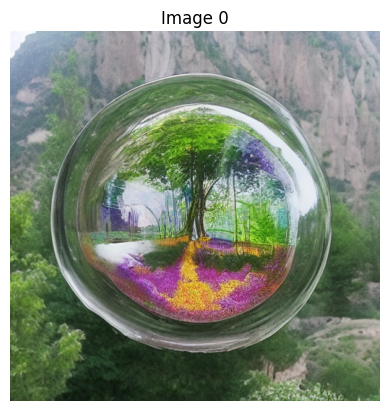

In [12]:
# Save Image
filename = "output"
results = list()
for (batch_number, image) in enumerate(images):
    i = 255. * image.cpu().numpy()
    img = Image.fromarray(np.clip(i, 0, 255).astype(np.uint8))
    filename_with_batch_num = filename.replace("%batch_num%", str(batch_number))
    file = f"{filename_with_batch_num}.png"
    img.save(os.path.join('.', file), compress_level=4)

    # Display image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Image {batch_number}")
    plt.axis('off')  # Hide axes
    plt.show()